In [11]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
import os
from deepxde.backend import pytorch

In [12]:
geom = dde.geometry.Rectangle([-1,-1],[1,1])
timedomain = dde.geometry.TimeDomain(0,10)
geomtime = dde.geometry.GeometryXTime(geom,timedomain)

In [13]:
alpha = 0.5
def pde(x,y):
    dy_t = dde.grad.jacobian(y,x,i=0,j=2)
    dy_xx = dde.grad.hessian(y,x,i=0,j=0)
    dy_yy = dde.grad.hessian(y,x,i=1,j=1)
    return dy_t - alpha * (dy_xx + dy_yy)

In [14]:
# 上边界，y=1
def boundary_t(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1)

# 下边界，y=-1
def boundary_b(x, on_boundary):
    return on_boundary and np.isclose(x[1], -1)

# 左边界，x=-1
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)

# 右边界，x=1
def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

bc_t = dde.icbc.NeumannBC(geomtime, lambda x:0, boundary_t)
bc_b = dde.icbc.NeumannBC(geomtime, lambda x:20, boundary_b)
bc_l = dde.icbc.DirichletBC(geomtime, lambda x:30, boundary_l)
bc_r = dde.icbc.DirichletBC(geomtime, lambda x:50, boundary_r)

In [15]:
def init_func(x):
    return 0

ic = dde.icbc.IC(geomtime,init_func,lambda _,on_initial:on_initial,)

In [16]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l,bc_r,bc_b,bc_t,ic],
    num_domain=8000,
    num_boundary=320,
    num_initial=800,
    num_test=8000,
)

layer_size = [3] + [50] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)

Compiling model...
'compile' took 0.000543 s



Training model...

0         [1.38e-02, 9.32e+02, 2.54e+03, 4.02e+02, 3.39e-02, 1.88e-02]    [1.34e-02, 9.32e+02, 2.54e+03, 4.02e+02, 3.39e-02, 1.88e-02]    []  


1000      [3.55e+01, 5.91e+00, 9.81e+01, 2.15e+01, 7.91e-01, 7.03e+00]    [2.57e+01, 5.91e+00, 9.81e+01, 2.15e+01, 7.91e-01, 7.03e+00]    []  
2000      [1.02e+01, 9.37e-01, 3.56e+00, 4.25e+00, 7.76e-01, 1.50e+00]    [7.33e+00, 9.37e-01, 3.56e+00, 4.25e+00, 7.76e-01, 1.50e+00]    []  
3000      [4.43e+00, 4.30e-01, 5.43e+00, 1.02e+00, 6.31e-01, 1.21e+00]    [2.83e+00, 4.30e-01, 5.43e+00, 1.02e+00, 6.31e-01, 1.21e+00]    []  
4000      [9.76e-01, 2.00e-01, 1.32e+00, 1.81e-01, 3.90e-01, 3.47e-01]    [1.22e+00, 2.00e-01, 1.32e+00, 1.81e-01, 3.90e-01, 3.47e-01]    []  
5000      [4.69e-01, 1.29e-01, 3.90e-01, 7.61e-02, 2.90e-01, 1.25e-01]    [1.16e+00, 1.29e-01, 3.90e-01, 7.61e-02, 2.90e-01, 1.25e-01]    []  
6000      [3.07e-01, 8.12e-02, 1.69e-01, 4.43e-02, 2.43e-01, 4.89e-02]    [1.12e+00, 8.12e-02, 1.69e-01, 4.43e-02, 2.43e-01, 4.89e-02]    []  
7000      [2.08e-01, 5.77e-02, 9.87e-02, 2.84e-02, 2.14e-01, 2.12e-02]    [1.16e+00, 5.77e-02, 9.87e-02, 2.84e-02, 2.14e-01, 2.12e-02]    []  

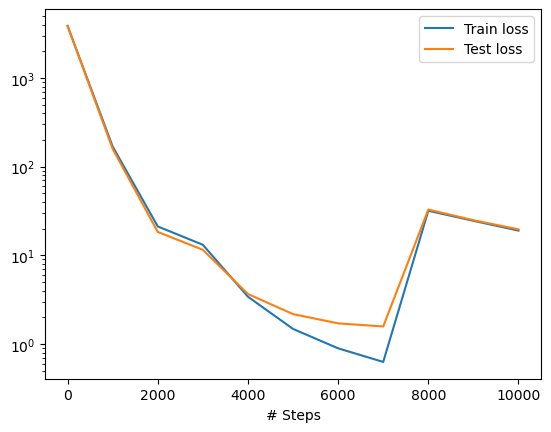

In [17]:
losshistory,train_state = model.train(iterations=10000,display_every=1000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

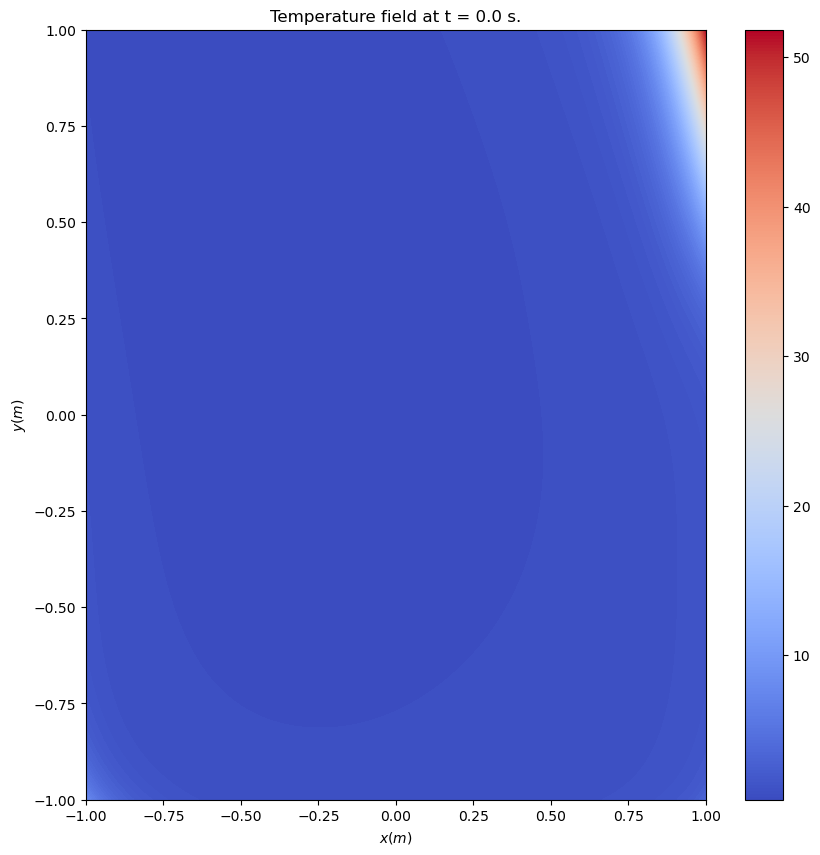

In [18]:
# x,y方向离散200个节点
x1 = np.linspace(-1,1,num=200,endpoint=True).flatten()
y1 = np.linspace(-1,1,num=200,endpoint=True).flatten()
xx1, yy1 = np.meshgrid(x1, y1)
x = xx1.flatten()
y = yy1.flatten()

# 时间上取20个时间步，时间步长1/20=0.05s
Nt = 20
dt = 1 / Nt

for n in range(0, Nt+1):
    t = n * dt
    t_list = t * np.ones((len(x), 1))
    x_pred = np.concatenate([x[:, None], y[:, None], t_list], axis=1)  # (B,3):x,y,t
    y_pred = model.predict(x_pred)  # (B,1):u
    y_p = y_pred.flatten()
    data_n = np.concatenate([x_pred, y_pred], axis=1)  # (B,4):x,y,t,u
    if n == 0:
        data = data_n[:, :, None]  # data数组中存的就是方程u(x,y,t)的数据集(B,4,n):B,x,y,t,t_id
    else:
        data = np.concatenate([data, data_n[:, :, None]], axis=2)  # (B,4,n):x,y,t,t_id

# 创建图片保存路径
work_path = os.path.join('2DtransientRectTC',)
isCreated = os.path.exists(work_path)
if not isCreated:
    os.makedirs(work_path)
    print("保存路径: " + work_path)

# 获得y的最大值和最小值
y_min = data.min(axis=(0,2,))[3]
y_max = data.max(axis=(0,2,))[3]
fig = plt.figure(100, figsize=(10, 10))

def anim_update(t_id):
    plt.clf()
    x1_t, x2_t, y_p_t = data[:, 0:1, t_id], data[:, 1:2, t_id], data[:, 3:4, t_id]  # (B,4,n):x,y,t,t_id  不选2:3的原因是2:3是t，而要用的是t_id
    x1_t, x2_t, y_p_t = x1_t.flatten(), x2_t.flatten(), y_p_t.flatten()
    plt.subplot(1,1,1)
    plt.tricontourf(x1_t, x2_t, y_p_t, levels=160, cmap="coolwarm")
    plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=y_min, vmax=y_max), cmap="coolwarm" ), ax=plt.gca())
    plt.xlabel('$x (m)$')
    plt.ylabel('$y (m)$')
    plt.title("Temperature field at t = " + str(round(t_id * dt,2)) + " s.", fontsize = 12)
    plt.savefig(work_path + '//' + 'animation_' + str(t_id) + '.png')

# 创建动画
anim =FuncAnimation(fig, anim_update, frames=np.arange(0, data.shape[2]).astype(np.int64), interval=200)
anim.save(work_path + "//" + "animation-" + str(Nt+1) + ".gif", writer="pillow",dpi=300)

In [9]:
print(data.shape)
x1, x2, t, y_p = data[:, 0:1, ], data[:, 1:2, ], data[:, 2:3, ], data[:, 3:4, ]
print(x1.shape, x2.shape, t.shape, y_p.shape)

(40000, 4, 21)
(40000, 1, 21) (40000, 1, 21) (40000, 1, 21) (40000, 1, 21)


In [10]:

x = np.save('heat_x', x1[:, 0, 0])  # (40000,)
y = np.save('heat_y', x2[:, 0, 0])  # (40000,)
t = np.save('heat_t', t[0, 0, :])  # (40000,)
u = np.save('heat_u', y_p[:, 0, :])  # (40000,21)

In [14]:
heat_x = np.load('../../data/heat_x.npy')
heat_y = np.load('../../data/heat_y.npy')
heat_t = np.load('../../data/heat_t.npy')
heat_u = np.load('../../data/heat_u.npy')
print(heat_x.shape, heat_y.shape, heat_t.shape, heat_u.shape)

(40000,) (40000,) (21,) (40000, 21)
